This chapter in Raschka focuses on the following:

* Obtaining unbiased estimates of a model's performance
* Diagnosing the common problems of machine learning algorithms
* Fine-tuning the models
* Evaluating models with a variety of different performance metrics.

Within scikit-learn, there is a class called *Pipeline*. The Pipeline class allows one to fit a model based on an arbitrary number of transformations of the feed data set and make predictions on new data coming in. Let's see it in action. 

We'll load in the **Wisconsin Breast Cancer** dataset. The class labels tell whether a tumor was malignant or benign, and the features are biological and based on images of cell nuclei.

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
                  header = None)

In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

LabelEncoder() has transformed our class labels M and B into the integers 1 and 0, respectively. Just to check on this:

In [3]:
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


Given what we learned in the last chapter, it would be a good idea to standardize our dataset, as well as transform it down into a lower-dimensional form. That way, we can train a logistic regression model with it. However, let's initialize an instance of the Pipeline class in order to chain all of these things together.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [7]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])

pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


What has this Pipeline object done for us? It takes a list of tuples as an input. The first value in the tuple is an arbitrary string identifier. This is used to pick out specific elements in a Pipeline as needed. The second elements are sklearn transformers or estimators.

Sp we've built out a pipeline for our machine learning model. What's the best way to evaluate the model's performance and find the best bias-variance tradeoff? 

We'll look at two techniques in this section: **holdout cross-validation** and **k-fold cross-validation**.

An important point: *If we continue to use the same test set to select a model through hyperparameter tuning, etc., our test set will essentially become a part of our training set, and overfitting will take place.*

Holdout cross-validation refers to splitting the data set into three parts: A training set to fit the model, a *validation* set to tune the hyperparameters, and a test set to make the final estimation of model performance.

This methodology is very sensitive to how the dataset is partitioned. Thus, it lacks the robustness necessary to properly evaluate a model. However, if we do it over and over again, then it might suffice. This is the idea behind **k-fold cross-validation**

We make *k* folds of our dataset without replacement, using *k-1* for training and 1 for testing. This is repeated *k* times and performance is averaged across all *k* models.

This is an important step in *hyperparameter tuning*.

AN even better version is the *stratified k-fold cross-validation* method, which ensures that each fold is representative of class label proportions. We'll use this in scikit-learn.

In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [9]:
skf = StratifiedKFold(  n_splits=10, #this is often a good choice for the values of k
                        random_state=1)

scores = []
for k, (train, test) in enumerate(skf.split(X_train,y_train)):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist: %s, Acc: %.3f' % 
            (k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist: [256 153], Acc: 0.891
Fold: 2, Class dist: [256 153], Acc: 0.978
Fold: 3, Class dist: [256 153], Acc: 0.978
Fold: 4, Class dist: [256 153], Acc: 0.913
Fold: 5, Class dist: [256 153], Acc: 0.935
Fold: 6, Class dist: [257 153], Acc: 0.978
Fold: 7, Class dist: [257 153], Acc: 0.933
Fold: 8, Class dist: [257 153], Acc: 0.956
Fold: 9, Class dist: [257 153], Acc: 0.978
Fold: 10, Class dist: [257 153], Acc: 0.956


We see that the stratified k-fold cross validation method kept the distribution of class labels consistent among the folds, and a different accuracy score for each fold has been obtained. We can now average them to see a complete view of our model accuracy.

In [10]:
print('CV Accuracy: %.3f +/- %.3f' % (
            np.mean(scores), np.std(scores)))

CV Accuracy: 0.950 +/- 0.029


As it happens, scikit-learn has a helpful cross validation scorer that can make the process even easier.

In [11]:
%%time
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=-1)

print('CV accuracy scores: %s' % scores)

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
Wall time: 1.34 s


In [12]:
%%time
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)

print('CV accuracy scores: %s' % scores)

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
Wall time: 59.7 ms


Looks like giving it the n_jobs=-1 parameter slows it down significantly. This should require it to use all CPUs available on my machine. But there must be some time that it takes to figure out what to use, and for a single CPU it will take longer necessarily. The amount of time is probably inflated due to the small size of this dataset.

In [13]:
print('CV accuracy: %.3f +/- %.3f' % (
            np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


So we get the same results.

Next we'll look at some debugging, diagnostics and validation techniques:

* **Learning curves** help diagnose if an algorithm has a problem with underfitting/overfitting.
* **Validation curves** help address common issues in our algorithms.

Learning curves help us make sure that we have a good tradeoff between bias and variance by tracking the training accuracy and the validation accuracy. Let's see one in scikit-learn.

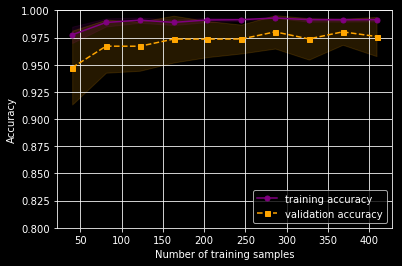

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = Pipeline([
            ('scl', StandardScaler()),
            ('clf', LogisticRegression(penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores = \
        learning_curve(estimator=pipe_lr,
                       X=X_train,
                       y=y_train,
                       train_sizes=np.linspace(0.1, 1.0, 10),
                       cv=10,
                       n_jobs=1)
    
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.style.use('dark_background')

plt.plot(train_sizes, train_mean,
         color='purple', marker='o',
         markersize=5,
         label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='purple')

plt.plot(train_sizes, test_mean,
         color='orange', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color='orange')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

We've plotted the training accuracy and validation accuracy based on the number of training samples we provide to the model. We see that the average accuracy is very high, which is good. However, the presence of a (relatively small) but noticeable gap between the accuracy plots may indicate some degree of overfitting.

Now that we've discovered potential overfitting within our model, we can try to use a validation curve to address the issue. Validation curves plot the training and test accuracies as a function of the model's *hyperparameters* rather than the number of samples.

In [15]:
from sklearn.model_selection import validation_curve

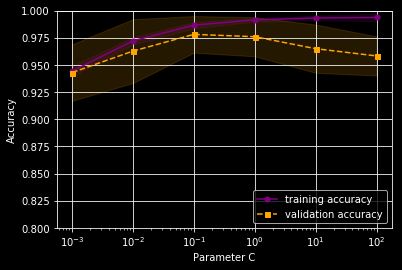

In [16]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(
                estimator=pipe_lr,
                X=X_train,
                y=y_train,
                param_name='clf__C',
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.style.use('dark_background')

plt.plot(param_range, train_mean,
         color='purple', marker='o',
         markersize=5,
         label='training accuracy')

plt.fill_between(param_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='purple')

plt.plot(param_range, test_mean,
         color='orange', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color='orange')

plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

We notice that the training and validation accuracies are both high when C = 0.1 and the gap is narrow. This seems like the "sweet spot" for this model in terms of regularization strength. We see that if we throw the model back into a training curve with C = 0.1:

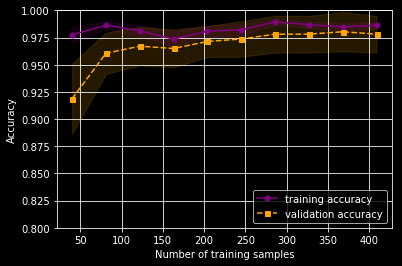

In [17]:
pipe_lr = Pipeline([
            ('scl', StandardScaler()),
            ('clf', LogisticRegression(penalty='l2', random_state=0, C=0.1))])

train_sizes, train_scores, test_scores = \
        learning_curve(estimator=pipe_lr,
                       X=X_train,
                       y=y_train,
                       train_sizes=np.linspace(0.1, 1.0, 10),
                       cv=10,
                       n_jobs=1)
    
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.style.use('dark_background')

plt.plot(train_sizes, train_mean,
         color='purple', marker='o',
         markersize=5,
         label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='purple')

plt.plot(train_sizes, test_mean,
         color='orange', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color='orange')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

The gap has decreased in size significantly.

There is a more powerful method of hyperparameter optimization called **grid search** that finds the optimal combination of hyperparameters for a model.

Grid search is a simple, brute force method. It just tests a range of values you give it for each hyper parameter and spits out the best result.

In [18]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.978021978022
{'clf__C': 0.1, 'clf__kernel': 'linear'}
Wall time: 15 s


In [19]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.978021978022
{'clf__C': 0.1, 'clf__kernel': 'linear'}
Wall time: 6.41 s


*Note: Now the n_jobs=-1 was faster, so it probably works as I had surmised earlier.*

Now we can use gs.best\_estimator_ to run the best-performing model against the test data.

In [20]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.965


Let's see if grid search got it right by looking at our validation and training curves for the linear SVM with C=0.1. 

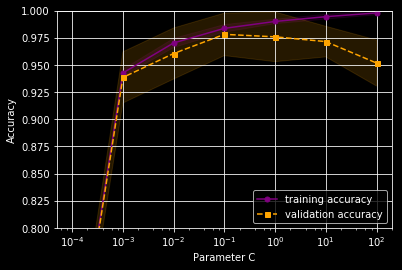

In [21]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1, kernel='linear',C=0.1))])

train_scores, test_scores = validation_curve(
                estimator=pipe_svc,
                X=X_train,
                y=y_train,
                param_name='clf__C',
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.style.use('dark_background')

plt.plot(param_range, train_mean,
         color='purple', marker='o',
         markersize=5,
         label='training accuracy')

plt.fill_between(param_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='purple')

plt.plot(param_range, test_mean,
         color='orange', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color='orange')

plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

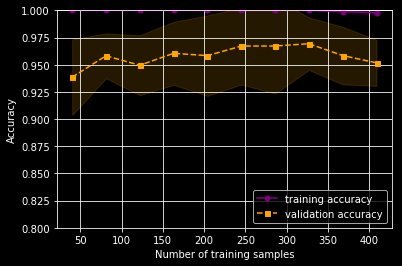

In [22]:
train_sizes, train_scores, test_scores = \
        learning_curve(estimator=pipe_svc,
                       X=X_train,
                       y=y_train,
                       train_sizes=np.linspace(0.1, 1.0, 10),
                       cv=10,
                       n_jobs=1)
    
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.style.use('dark_background')

plt.plot(train_sizes, train_mean,
         color='purple', marker='o',
         markersize=5,
         label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='purple')

plt.plot(train_sizes, test_mean,
         color='orange', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color='orange')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

Grid search is a great way to fine tune hyperparameters. However, what if we're trying to select among many different machine learning algorithms to find the one that works best for our particular dataset?

**Nested cross-validation** is one way of doing this. It tunes parameters iteratively via k-folds cross-validation inside a loop of k-folds itself, where each of the folds in the outer loop partitions the dataset differently.

In [23]:
pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))])

gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print('CV accuracy: %.3f +/- %.3f' % (
            np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


The purpose of this is to give a good idea of what to expect from performing hyperparameter tuning. We can extend this process to a different machine learning algorithm and see what results we obtain.

In [24]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=0),
        param_grid= [{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
        scoring = 'accuracy',
        cv=2)

scores = cross_val_score(gs,
                         X_train,
                         y_train,
                         scoring='accuracy',
                         cv=5)

print('CV accuracy: %.3f +/- %.3f' % (
            np.mean(scores), np.std(scores)))

CV accuracy: 0.921 +/- 0.029


We see that on average, the SVC performed markedly better than the decision tree, so we would likely procees with hyperparameter optimization of the SVC model.

However, accuracy isn't always going to be the performance metric of choice for the models we make.

A convenient structure in the scikit-learn library is the confusion matrix, which lays out the performance of an algorithm in a Punnett square-like structure.

In [25]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


The confusion matrix tells us that there were 71 True Positives, 2 False Positives, 1 False Negative, and 40 True Negatives. Let's see a cool way to visualize this matrix.

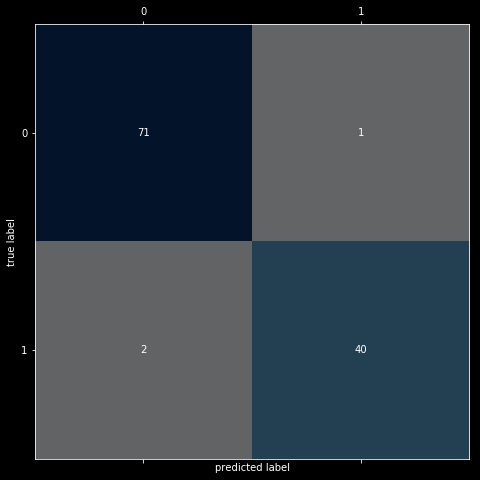

In [26]:
fig, ax = plt.subplots(figsize=(8.0,8.0))

plt.style.use('dark_background')

ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
                s=confmat[i, j],
                va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

Metrics we look at involving the confusion matrix are things like the False Positive (FP) and True Positive (TP) rates. These, along with False Negative (FN) lead to some useful metrics: **precision** and **recall**.

$$PRE = \frac{TP}{TP + FP}$$
$$REC = \frac{TP}{FN + TP}$$

Often these scores are combined into the so-called **F1-score**.

$$F1 = 2\frac{PRE \times REC}{PRE + REC}$$

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(
            y_true=y_test, y_pred=y_pred))

Precision: 0.976


In [28]:
print('Recall: %.3f' % recall_score(
            y_true=y_test, y_pred=y_pred))

Recall: 0.952


In [29]:
print('F1: %.3f' % f1_score(
            y_true=y_test, y_pred=y_pred))

F1: 0.964


We can provide different metrics to GridSearch for fine-tuning our hyperparameters. Also, we can edit which of our class labels - 0 or 1, represents the "positive" class by using the *make_scorer* function in scikit-learn.

In [30]:
from sklearn.metrics import make_scorer, f1_score

scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)

"""scores = cross_val_score(gs,
                         X_train,
                         y_train,
                         scoring=scorer,
                         cv=5)"""

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
# print('F1 score: %.3f +/- %.3f' % (
              #  np.mean(scores), np.std(scores)))


0.982798668208
{'clf__C': 0.1, 'clf__kernel': 'linear'}


There's another plot that can be helpful in assessing the performance of a model called a **Receiver operator characteristic** or **ROC** graph. The diagonal of the graph essentially represents random guessing on the part of the model. Anything below that line is worse than a random guess. Anything above that line is better.

The curve represents our model, and the **Area-under-the-curve** or **AUC** represents the model's performance. The next plot will show the ROC plot for our breast cancer data, but for only two features. The added difficulty for the model to only consist of two features will make the plot more interesting.

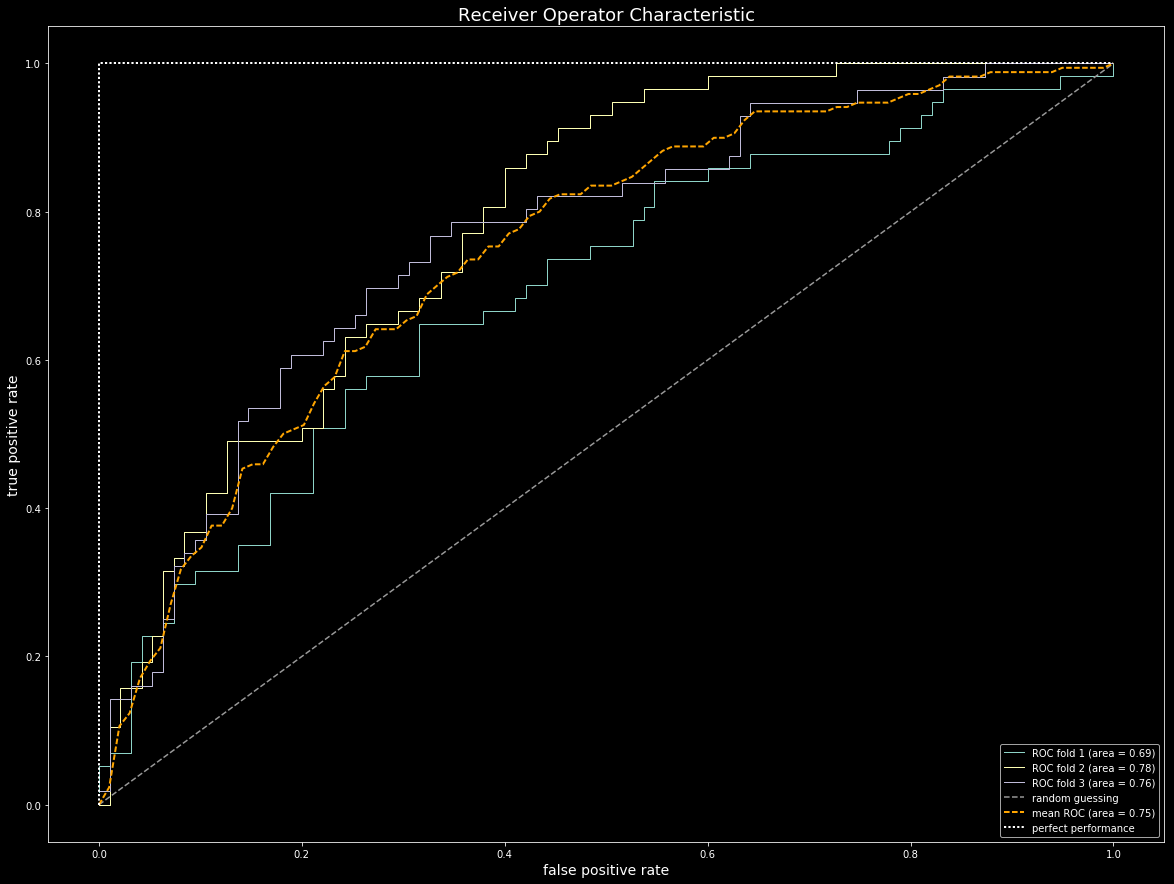

In [35]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2',
                                               random_state=0,
                                               C=100.0))])

X_train2 = X_train[:, [4, 14]]

cv = StratifiedKFold(n_splits=3,
                     random_state=1)

plt.style.use('dark_background')

fig = plt.figure(figsize=(20,15))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv.split(X_train2, y_train)):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
    
plt.plot([0,1],
         [0,1],
         linestyle= '--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= cv.get_n_splits()

mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--',
         color='orange',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='white',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate',fontsize=14)
plt.ylabel('true positive rate', fontsize=14)
plt.title('Receiver Operator Characteristic',fontsize=18)
plt.legend(loc='lower right')
plt.show()

So the code to generate this was a little heavy. Essentially, each of the ROC curves represents a single fold from a StratifiedKFold class instance. The diagonal dotted line is the "Random guess" line. The area under each of these curves can be thought of as the performance of the model. The squiggly orange dotted line is the mean of our 3-fold interpolation, and the squareish function represents perfect model performance. If we calculated the area under the perfect performance curve, we would get 1.

If we don't need a cool chart, we can get a simple metric for looking at ROC_AUC values.

In [32]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

print('ROC_AUC: %.3f' % roc_auc_score(
            y_true=y_test, y_score=y_pred2))

print('Accuracy: %.3f' % accuracy_score(
            y_true=y_test, y_pred=y_pred2))

ROC_AUC: 0.662
Accuracy: 0.711


A very important point must be made here: All of these metrics thus far have been for *binary classification problems **only***. But, there are *micro* and *macro* versions of these metrics that can be implemented in order to extend their effectiveness to **One vs. All (OvA)** classification as well. For example, the micro and macro versions of precision for a k-class system:

$$PRE_{micro} = \frac{TP_{1} + ... + TP_{k}}{TP_{1} + ... + TP_{k} + FP_{1} + ... +FP_{k}}$$

$$PRE_{macro} = \frac{PRE_{1} + ... + PRE_{k}}{k}$$

Macro is the default calculation when using binary classifier metrics on a multiclass problem,  but we can force scikit-learn to calculate differently.

In [33]:
pre_scorer = make_scorer(score_func = precision_score,
                         pos_label=1,
                         greater_is_better=True,
                         average='micro')

In summary, the following topics were discussed in this chapter:

* Pipelining data preparation steps into a single entity
* Utilizing pipelines to perform k-fold cross-validation
* Plotting learning and validation curves
* Fine-tuning via grid search
* Evaluating binary classifiers in various ways

Next chapter: Combining Different Models for Ensemble Learning